## Load in 17311 WT data and get a feel for it

The data here corresponds to the longest 1000 trajectories. The first 10 frames (50 ns) were discarded before computing distances. Distances were computed every 5 frames (2.5 ns). 

In [1]:
import pyemma
import pickle
import matplotlib.pyplot as plt
import numpy as np

In [2]:
# Load in nested dict of timeseries data
# Key: clone, Value: dict of Key: residue-pair, Value: distances for each frame
with open("17311_RUN3_longest1000_timeseries.pickle", "rb") as f:
    d_timeseries = pickle.load(f)

In [3]:
# Check which residue pairs we computed distances for
d_timeseries[1].keys()

dict_keys(['d30_res417_mindist', 'e329_res439_mindist', 'e484_k31_mindist', 'e35_k31_mindist', 'e35_q493_mindist', 'q493_k31_mindist', 'k353_g496bb_mindist', 'd38_y449_dist_mindist', 'q42_y449_dist_mindist', 'k353bb_g502bb_dist_mindist'])

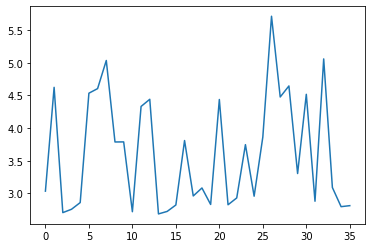

In [4]:
# Check what the timeseries of 417 distances looks like for CLONE1
plt.plot(d_timeseries[1]['d30_res417_mindist'])
plt.show()

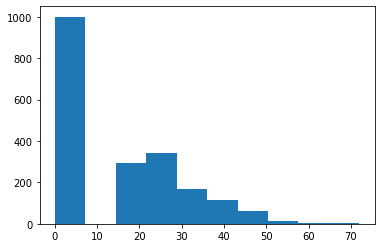

In [5]:
# Check how many frames are in each traj (note: this is after discarding the first 10 frames)
# Note: Ignore the trajs of length 0 -- these trajs were not analyzed to minimize analysis time
lengths = [len(d_timeseries[key]['d30_res417_mindist']) for key in d_timeseries]
plt.hist(lengths)
plt.show()

## Now, let's run tica

In [6]:
# The input for tica needs to be a list of lists with the following dimensions:
# (number of trajs, number of frames, number of residue pairs)
# Let's generate that list
for_tica = []
for clone in range(2000):
    distances = []
    for residue_pair in d_timeseries[clone]:
        distances.append(d_timeseries[clone][residue_pair])
    distances_transpose = np.array(distances).T
    if len(distances_transpose) > 0: # only add clones that have distances computed
        for_tica.append(distances_transpose)
        

In [7]:
tica = pyemma.coordinates.tica(for_tica, lag=1) 

# The lag time (units: number of frames) doesn't matter, make it as short as possible 
# Will need to play around with:
# Kinetic map -- multiplies output coordinate by sqrt(eigenvalue), eigenvalues depend on lag time, so need to find sweet spot where this works best
# Commute map -- removes dependence on lag time by using timescales (multiplies output coordinate by timescales -- slowest thing gets multiplied by fastest timescale, fastest gets multiplied by the slowest timescale)
# dim -- how many tics you get out, -1 means you get out as many tics as numbers of features that capture var_cutoff variance 
# var_cutoff -- % cutoff variance for which to select number of tics

100%|██████████| 1000/1000 [00:00<00:00, 2448.30it/s]                      


In [8]:
tica

TICA(commute_map=False, dim=-1, epsilon=1e-06, kinetic_map=True, lag=1,
   ncov_max=inf, reversible=True, skip=0, stride=1, var_cutoff=0.95,
   weights=None)

In [9]:
tica_output = tica.get_output()

100%|██████████| 1000/1000 [00:00<00:00, 6443.74it/s]                       


In [30]:
# Let's look at the tica output for the first traj
tica_output[0].shape 
# only 6 (not 10) tics used because these capture 95% of variance (tics do not directly correspond to features)
# 36 corresponds to number of frames in the first traj

(36, 6)

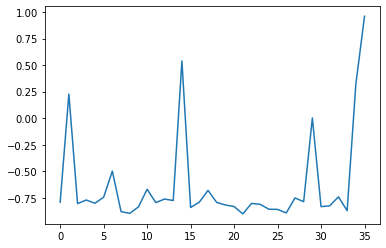

In [33]:
# Plot first tic for each frame for first trajectory
plt.plot(tica_output[0][:,0]) 
# This shows that there is some slowness in this tic -- most of the time its at -0.75

In [38]:
# Now, let's look at the correlation matrix between tics and residue-pairs
tica.feature_TIC_correlation

array([[-5.99074578e-02,  1.21705980e-01,  5.39726861e-01,
         3.19685706e-02, -1.41544653e-02,  8.87735033e-04],
       [ 7.11182791e-03,  1.45023754e-02,  5.35536066e-03,
         1.83272505e-02, -1.01800985e-03, -4.49643866e-03],
       [-3.22424999e-03, -1.71589721e-02, -1.00721497e-02,
        -9.39822618e-03, -1.20687265e-01,  1.62781836e-01],
       [-2.76833911e-02,  5.57786606e-02,  1.12061704e-02,
         5.08385011e-03,  2.04854842e-01,  1.47569246e-01],
       [-2.39606559e-02,  9.40669091e-03,  1.56837505e-02,
         3.62421340e-02,  8.63800979e-02, -1.24672102e-02],
       [-1.48548919e-02,  6.14616876e-02,  3.06030800e-02,
         2.87320823e-02,  3.50663226e-01, -4.05415541e-03],
       [ 4.62953927e-02,  1.78584337e-01, -7.86053153e-02,
         4.34902088e-01, -2.03839598e-02, -3.63661874e-05],
       [ 7.58766685e-01,  1.81766088e-01, -8.80986936e-03,
        -2.10669076e-02, -4.07004841e-03, -1.78635362e-03],
       [ 7.38110275e-01, -2.15565651e-01,  4.845

In [36]:
tica.feature_TIC_correlation.shape # 10 distances, 6 tics

(10, 6)

In [42]:
# Check the correlations between each residue-pair and the first tic
tica.feature_TIC_correlation[:,0]

array([-0.05990746,  0.00711183, -0.00322425, -0.02768339, -0.02396066,
       -0.01485489,  0.04629539,  0.75876668,  0.73811027, -0.02728358])

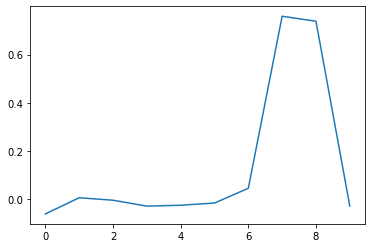

In [43]:
# Plot the correlation with tic 0 vs. residue-pair
plt.plot(tica.feature_TIC_correlation[:,0]) 
# Note the points in the plots should not be connected
# The 7th and 8th residue pairs are the slowest reaction coordinate

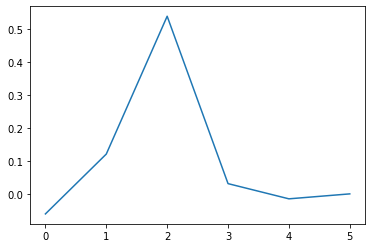

In [65]:
# Plot the correlation with residue-pair 0 vs. tic
plt.plot(tica.feature_TIC_correlation[0,:])

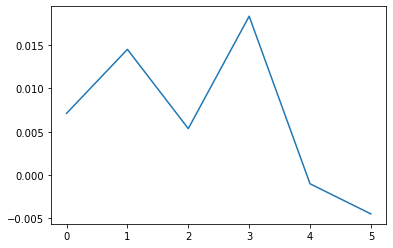

In [67]:
# Plot the correlation with residue-pair 1 vs. tic
plt.plot(tica.feature_TIC_correlation[1,:])
# residue pair 1 is not highly correlated with any of the tics, meaning it doesn't contribute much to the slowest processes

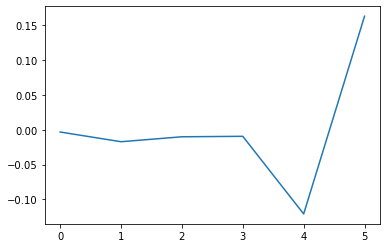

In [92]:
# Plot the correlation with residue-pair 2 vs. tic
plt.plot(tica.feature_TIC_correlation[2,:])
# residue pair 2 is not highly correlated with any of the tics, meaning it doesn't contribute much to the slowest processes

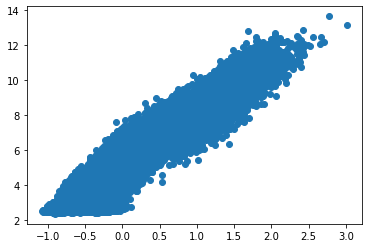

In [49]:
# For all frames, plot distance for residue pair 7 vs. the first tic
plt.scatter(np.concatenate([traj[:, 0] for traj in tica_output]), np.concatenate([traj[:, 7] for traj in for_tica])) 
# These are correlated -- which matches what we observed above by using the correlation coefficient matrix
# to plot correlation with tic 0 vs. residue-pair

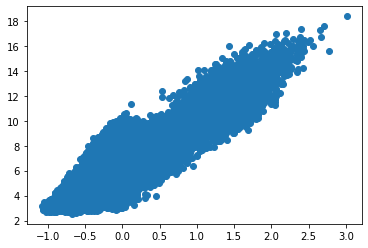

In [51]:
# For all frames, plot distance for residue pair 8 vs. the first tic
plt.scatter(np.concatenate([traj[:, 0] for traj in tica_output]), np.concatenate([traj[:, 8] for traj in for_tica])) # x is the first tic for all frames, y is the 7th residue-pair 

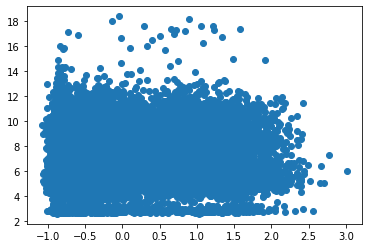

In [50]:
# For all frames, plot distance for residue pair 2 vs. the first tic
plt.scatter(np.concatenate([traj[:, 0] for traj in tica_output]), np.concatenate([traj[:, 2] for traj in for_tica]))
# Little to no correlation -- which matches what we observed above by using the correlation coefficient matrix
# to plot correlation with tic 0 vs. residue-pair

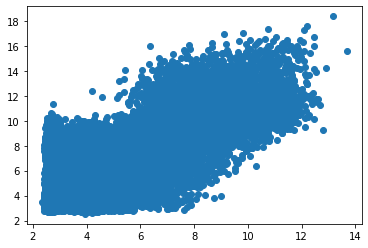

In [52]:
# Plot distance for the 7th residue pair vs. distance for the 8th residue-pair
plt.scatter(np.concatenate([traj[:, 7] for traj in for_tica]), np.concatenate([traj[:, 8] for traj in for_tica]))
# For large distances (> 9), they are correlated
# For smaller distances, there is a mix of mutual exclusivity (one residue pair close, but not the other) and both residue pairs being close

(array([7.131e+03, 6.235e+03, 4.784e+03, 2.126e+03, 2.429e+03, 2.779e+03,
        1.614e+03, 3.600e+02, 5.400e+01, 5.000e+00]),
 array([-1.0763605 , -0.6678765 , -0.2593925 ,  0.14909148,  0.55757546,
         0.96605945,  1.3745434 ,  1.7830274 ,  2.1915114 ,  2.5999954 ,
         3.0084794 ], dtype=float32),
 <BarContainer object of 10 artists>)

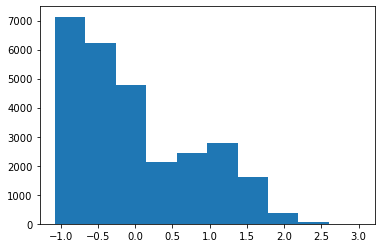

In [53]:
# Plot distribution of first tic for all the data
plt.hist(np.concatenate([traj[:, 0] for traj in tica_output]))

(array([286., 147., 126.,  76.,  86.,  90., 112.,  66.,   7.,   4.]),
 array([-0.9681923 , -0.63416594, -0.30013958,  0.03388678,  0.36791313,
         0.70193946,  1.0359658 ,  1.3699923 ,  1.7040186 ,  2.038045  ,
         2.3720713 ], dtype=float32),
 <BarContainer object of 10 artists>)

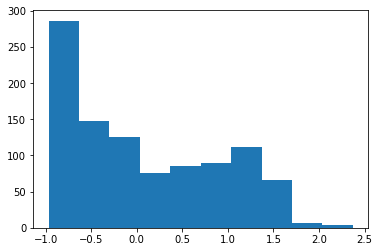

In [55]:
# Plot distribution of first tic for first frames for all data
plt.hist([traj[0, 0] for traj in tica_output]) 
# Distribution looks the same for first frame vs all frames, meaning this system is already equilibrated 
# and this process isn't slow, and this should be happening across the whole trajectory 
# We won't be sure if the process is too fast until we build the MSM
# To determine how similar these distributions are, can calculate the KL divergence

In [ ]:
# TO DO:
# Look at 10 frames with low tics and 10 frames with high tics
# Look at trajectory with largest tic value
# Can also grab every 10 or so frames from smallest tica value to largest, and make a synthetic trajectory, then smooth it in pymol

In [61]:
# Get list of max tic values for each trajectory
maxes = []
for traj in tica_output:
    maxes.append(np.max(traj[:, 0]))

In [62]:
# Get the trajectory with the largest tic value
np.argmax(maxes)

216

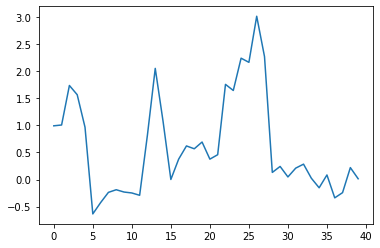

In [63]:
# Plot timeseries of the first tic for trajectory 216
plt.plot(tica_output[216][:,0]) 

## Now, let's cluster the tics

In [73]:
clusters = pyemma.coordinates.cluster_kmeans(tica_output, k=50, max_iter=100)
# k -- choose 50 or 100 to start depending on how big the dataset is
# max_iter = use 10 or 100 depending on dataset size

100%|██████████| 50/50 [00:00<00:00, 148.56it/s]                             

100%|██████████| 100/100 [00:01<00:00, 51.52it/s]


In [78]:
cluster_output = clusters.dtrajs

100%|██████████| 1000/1000 [00:04<00:00, 205.03it/s]                                   


In [79]:
cluster_output

[array([21, 35, 21, 21, 21, 28, 41, 28, 32, 21,  5, 28, 28, 21, 14, 21, 28,
        45, 21,  5, 28, 13, 21, 21, 21, 28, 28, 28, 28, 44, 28, 21, 28, 21,
        37, 25], dtype=int32),
 array([16,  7, 13, 11, 40, 11, 20, 41, 35, 37, 37,  1, 44, 28, 27, 13, 45,
        41, 28,  9,  9,  9, 28, 44, 39, 45, 41, 42, 41, 41,  5, 41, 31, 44,
        11, 16, 36, 16, 16, 16, 16, 16, 16, 16, 16, 16, 36, 36],
       dtype=int32),
 array([ 4, 25,  8,  8, 25, 12, 37,  8, 25,  4, 44, 21, 28, 37, 28, 32, 45,
        21, 21, 21,  0, 21], dtype=int32),
 array([ 8,  8, 12,  4,  4, 26, 37, 32, 32, 40, 13, 44, 35, 27, 41, 28,  0,
         9, 44, 18], dtype=int32),
 array([32, 21, 28, 21,  5, 21, 24,  9, 15,  0,  0, 28,  7, 13, 21, 41,  0,
        45,  7,  7, 45, 23,  7,  5, 37, 44,  0,  0, 32, 34,  0,  0, 34,  0,
        37, 24,  0,  9, 15, 32, 39,  5, 41,  9], dtype=int32),
 array([21, 21, 41,  5, 45, 41, 41, 42,  2, 29,  2, 45, 41, 41, 41, 41, 41,
        41, 41, 41, 41, 45, 41, 10, 41, 41, 41, 45, 41, 41

In [80]:
# Compute implied timescales -- computes multiple msms at diff lag times
its = pyemma.msm.its(cluster_output) 

100%|██████████| 7/7 [00:01<00:00,  3.99it/s]                                 


<AxesSubplot:xlabel='lag time / steps', ylabel='timescale / steps'>

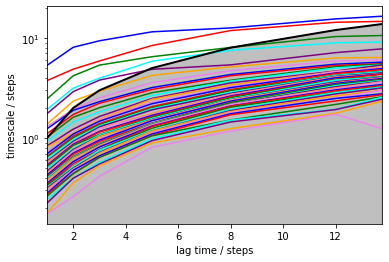

In [81]:
pyemma.plots.plot_implied_timescales(its) 
# Each line corresponds to a slow process (number processes = number of clusters - 1, so 49)
# Gray area -- lag time has become longer than the timescale of the process
# If we want to make an msm based on this data, we need to use lag time < 12 because its hitting gray region there
# perhaps these distances are not good descriptors of the slowest process because these distances describe a pretty fast timescale


## Build MSM

In [82]:
msm = pyemma.msm.estimate_markov_model(cluster_output, 7) 
# Alternatives to `estimate_markov_model`: hidden - coarse grained, augumented - with experimental data
# Choose 7 as lag time because it looks flat after lag time 7

In [84]:
msm.active_state_fraction 
# This you how many states we've kept (here, we've kept all state)
# Sometimes states are discarded if there are no transitions in both directions for that state

1.0

In [86]:
msm.eigenvectors_right 
# eigenvectors_left -- eigenvectors multiplied by the populations
# eigenvectors_right -- eigenvectors themselves

<bound method MSM.eigenvectors_right of MaximumLikelihoodMSM(connectivity='largest', core_set=None,
           count_mode='sliding', dt_traj='1 step', lag=7, maxerr=1e-08,
           maxiter=1000000, milestoning_method='last_core',
           mincount_connectivity='1/n', reversible=True, score_k=10,
           score_method='VAMP2', sparse=False, statdist_constraint=None)>

In [87]:
eigenvectors = msm.eigenvectors_right()

In [88]:
eigenvectors.shape # dimensions: states, value of eigenvector


(50, 50)

In [90]:
# Let's check that we have the dimensions right
eigenvectors[:, 0] # First eigenvector is equilibrium should be flat 

array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.])

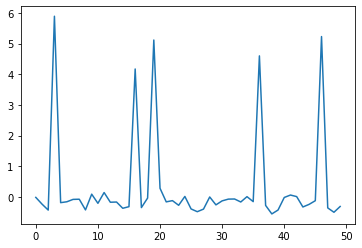

In [91]:
# Plot slowest eigenvector vs. states
plt.plot(eigenvectors[:,1]) # slowest eigenvector
# There's 5 microstates that form one macrostate, all the rest are another macrostate --> 2 macrostates

In [ ]:
# TODO:
# Can look at which state has the lowest vs highest -- in pymol
# What is the difference in distributions in the 5 states with spikes